In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import json
import fnmatch

In [11]:
list1=[x[0] for x in os.walk('../base loads/')][1:]
print(list1)

['../base loads/FR', '../base loads/LH', '../base loads/LO', '../base loads/MO', '../base loads/OP', '../base loads/PS', '../base loads/QR', '../base loads/Res', '../base loads/Rstand', '../base loads/Rstrip', '../base loads/SO', '../base loads/SS', '../base loads/WH']


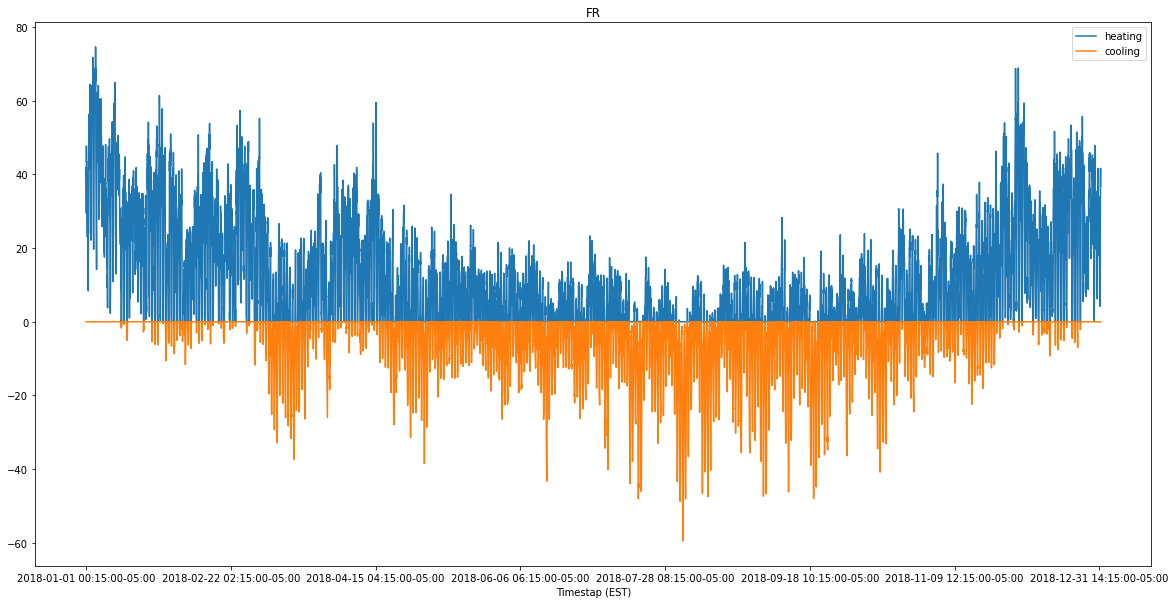

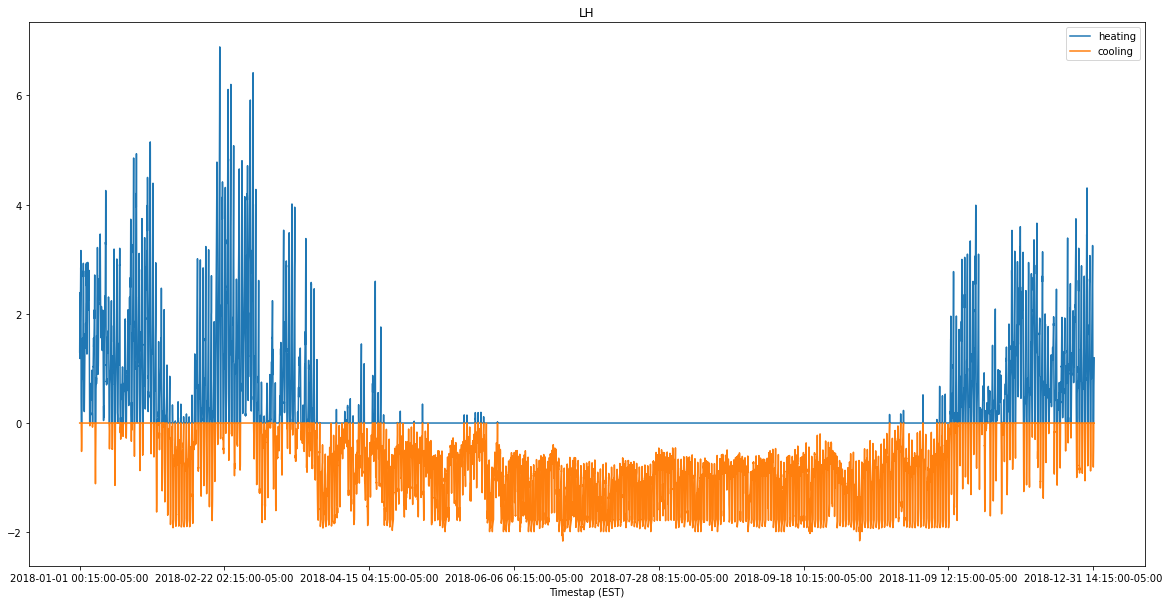

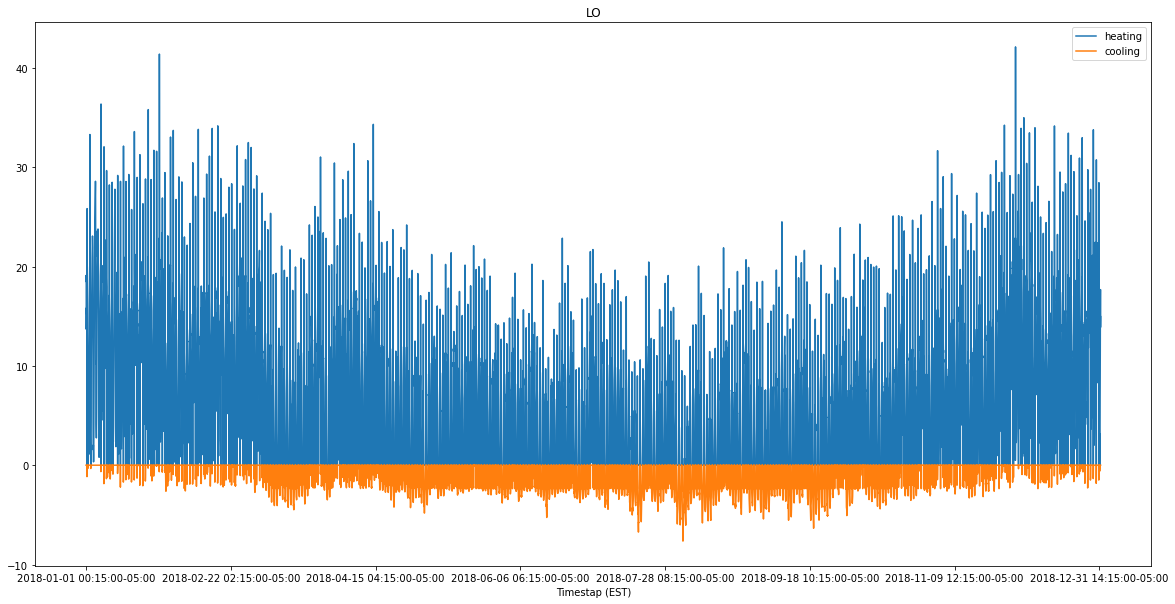

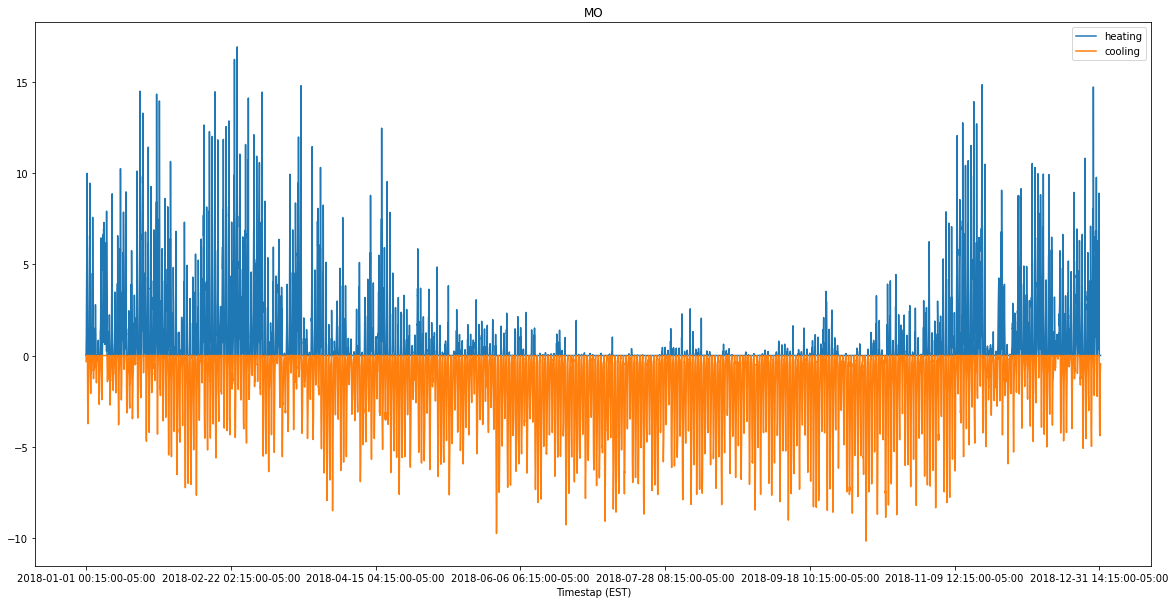

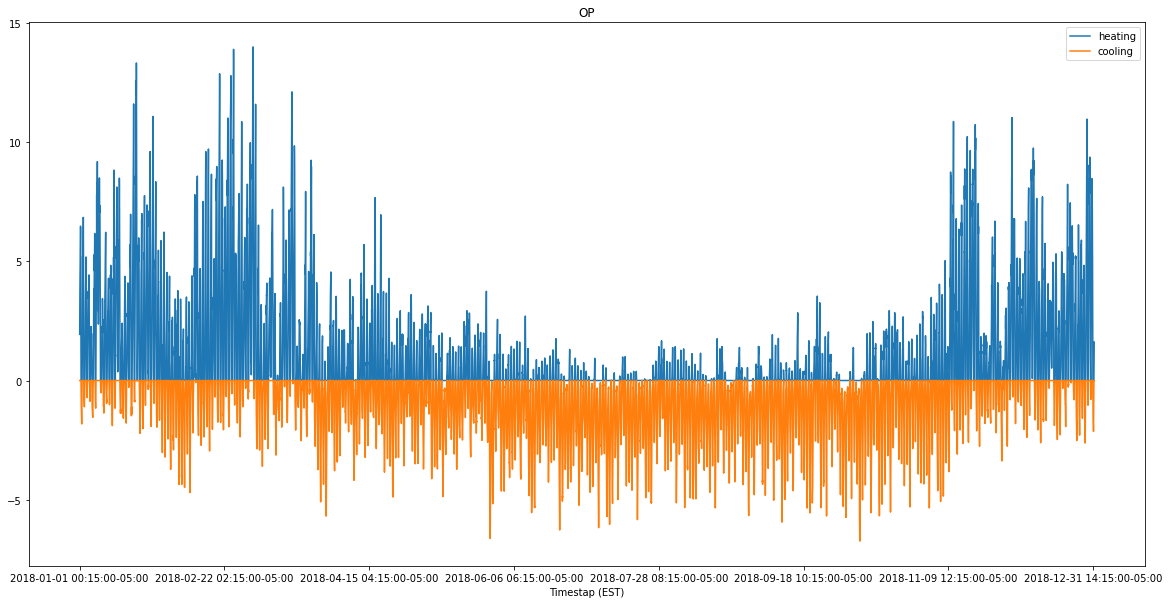

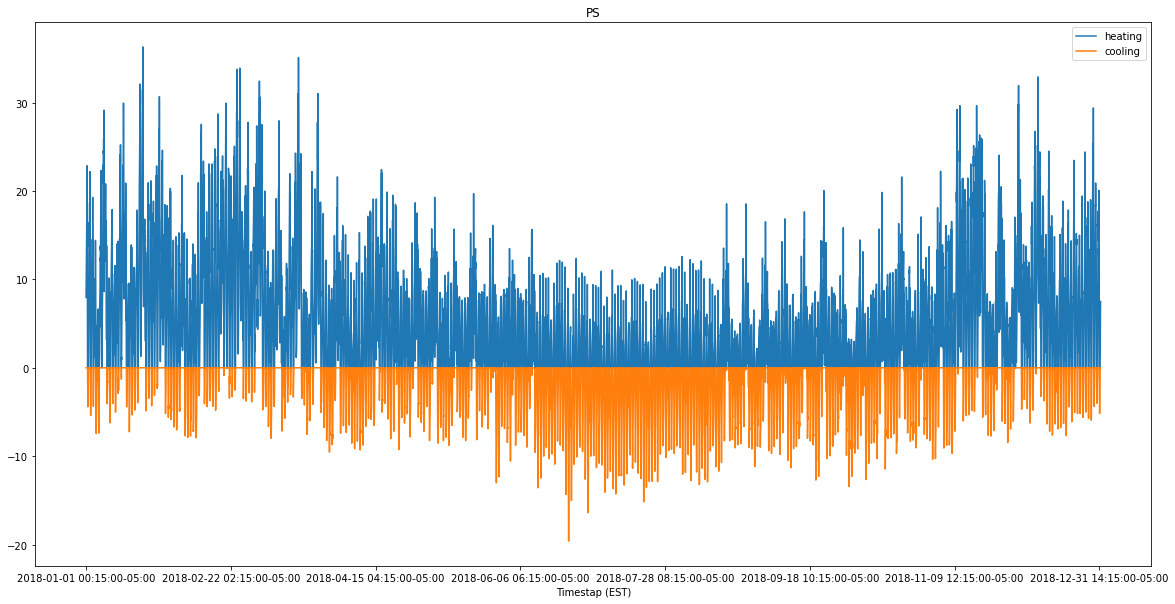

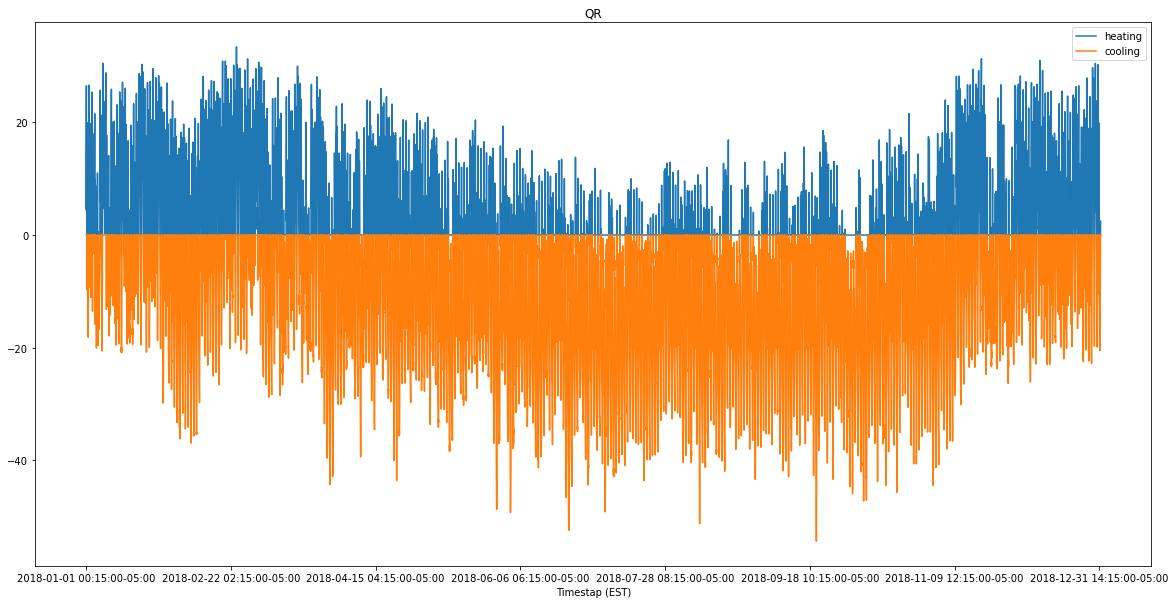

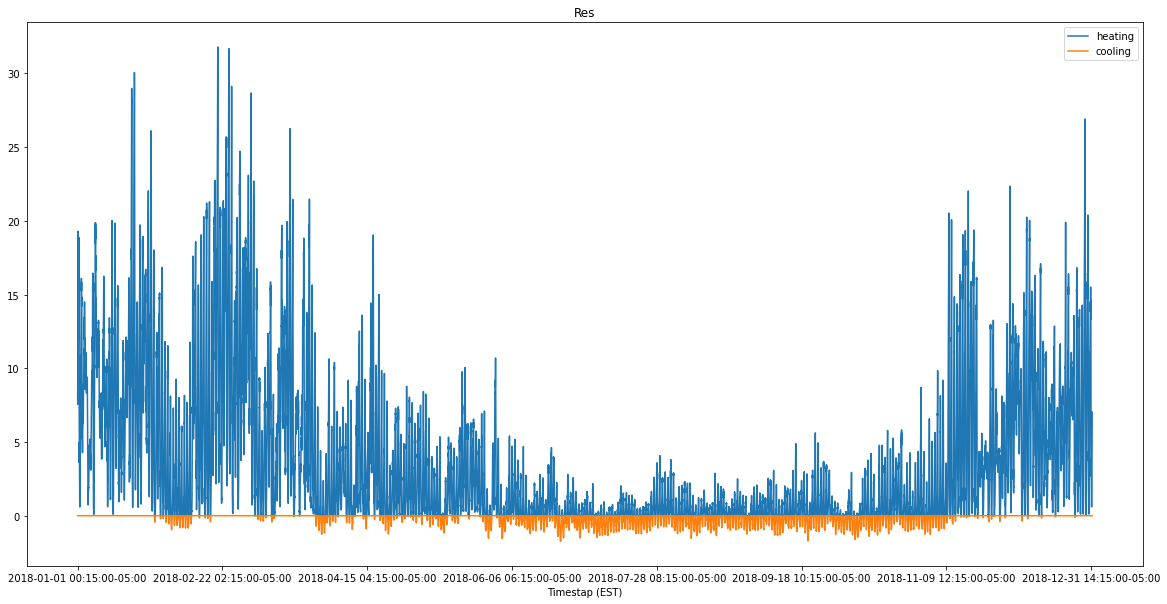

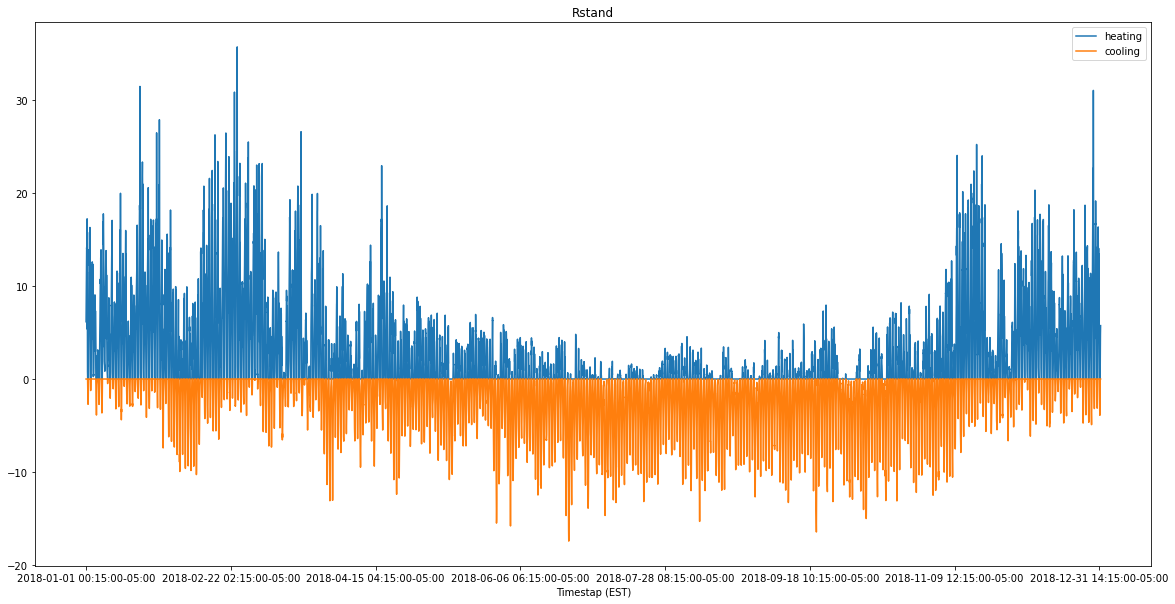

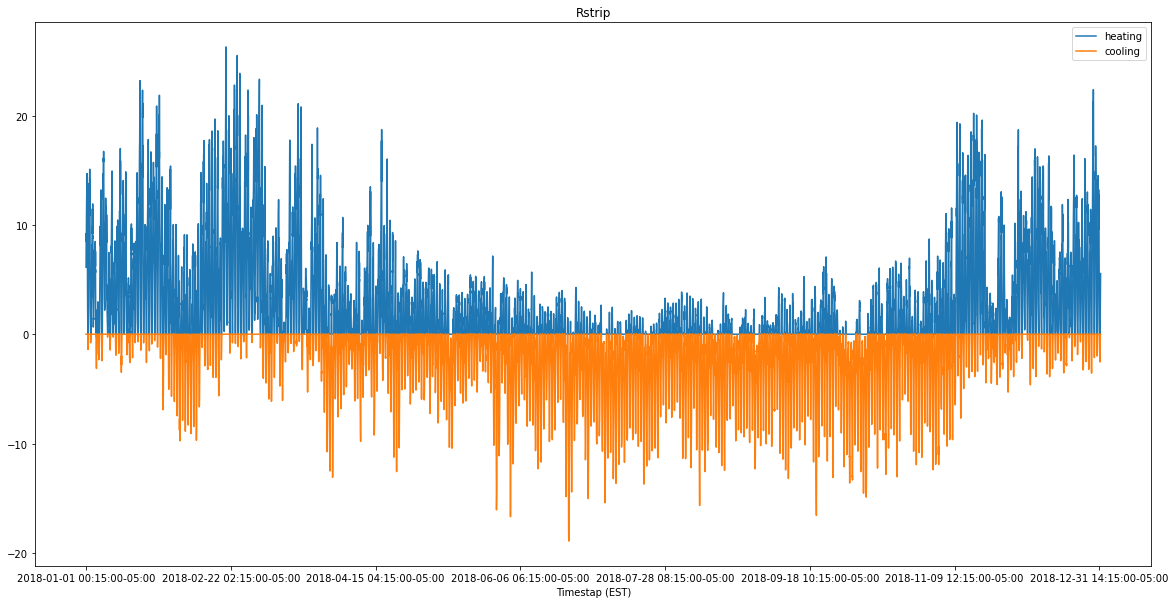

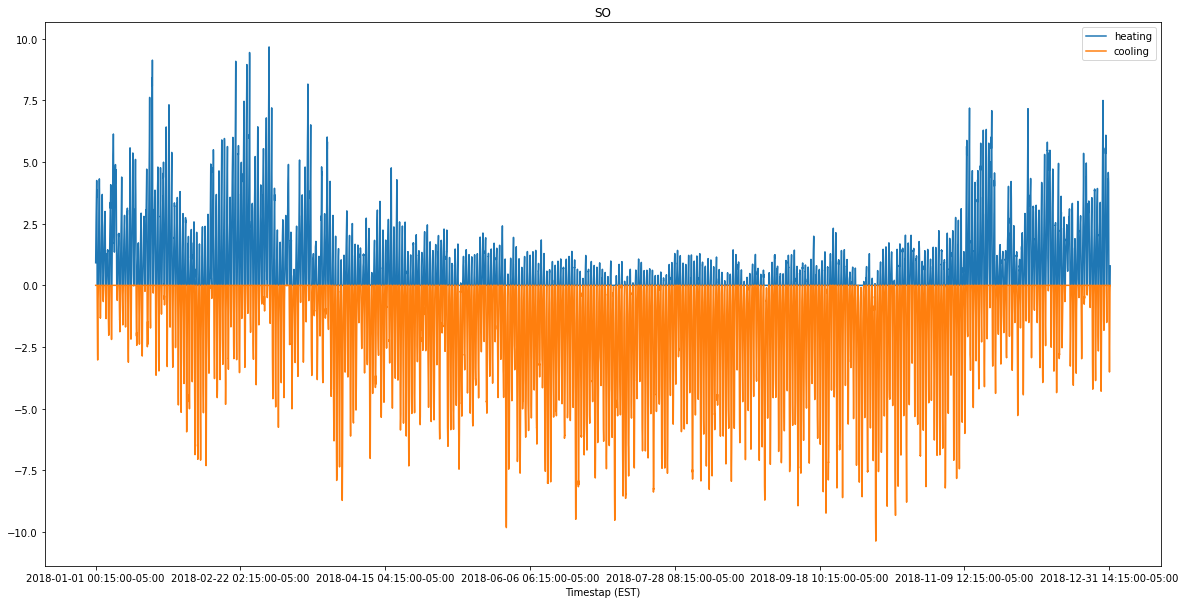

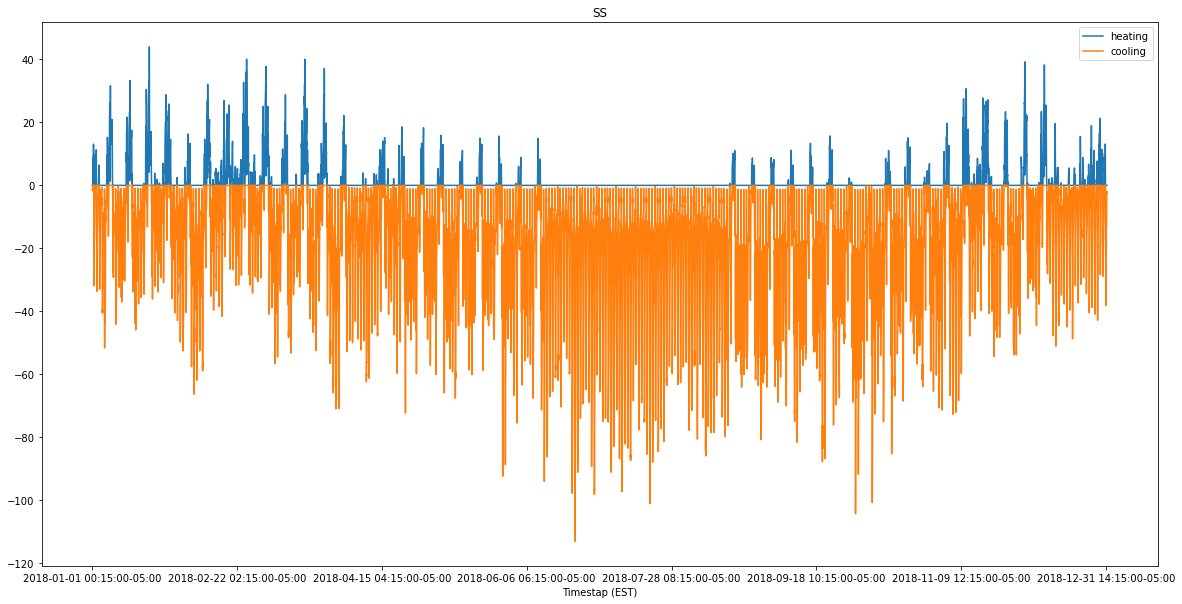

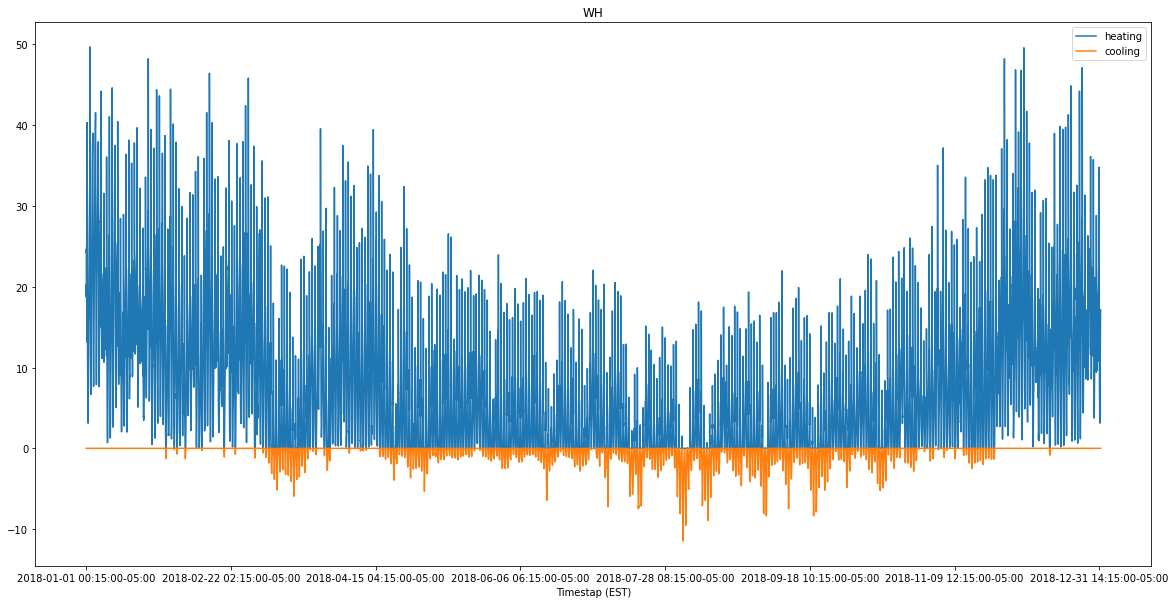

In [31]:
name_list=[]
area_list=[]
for file1 in list1:
    df = pd.read_csv (file1+'/15_minute_timeseries_data.csv')
    df2 = pd.read_csv (file1+'/Building_Characteristics.csv')
    area=(df2.option.values*df2.value.values).sum()*0.092903
    df_heating=df[df.columns[df.columns.str.contains('.heating.')]].sum(axis=1)/area*1000*4
    df_cooling=-df[df.columns[df.columns.str.contains('.cooling.')]].sum(axis=1)/area*1000*4
    df_net=df_cooling+df_heating
    df_cooling=df_net.copy()
    df_heating=df_net.copy()
    df_cooling[df_cooling>0]=0
    df_heating[df_heating<0]=0
    df['cooling']=df_cooling
    df['heating']=df_heating
    df['time']=(df.index.values+1)*60*15
    df.plot(x='Timestap (EST)',y=['heating','cooling'],figsize=(20,10),title=file1.split('/')[2])
    df[['time','cooling','heating']].to_csv('../result loads/'+file1.split('/')[2]+'.csv', sep='\t')
    name_list.append(file1.split('/')[2])
    area_list.append((df2.option.values*df2.value.values).sum()/df2.value.values.sum())
plt.show()

In [33]:
area_dict=dict(zip(name_list,area_list))
area_dict

{'FR': 4792.0353982300885,
 'LH': 75000.0,
 'LO': 350000.0,
 'MO': 87500.0,
 'OP': 37500.0,
 'PS': 75000.0,
 'QR': 2000.0,
 'Res': 1335.7769374204904,
 'Rstand': 23941.176470588234,
 'Rstrip': 28613.013698630137,
 'SO': 10473.684210526315,
 'SS': 166666.66666666666,
 'WH': 53132.45033112583}

In [2]:
BIM=pd.read_csv('../berkeley/Berkeley_UrbanSim.csv') 
with open('../berkeley/TypeID.json') as json_file:
    ID = json.load(json_file)
index=[]
btype=[]
for i in range(len(ID)):
    index.append(ID[i]['TypeId'])
    btype.append(ID[i]['Occupancy'])
id_dict=dict(zip(index,btype))
id_dict

{0: 'Other/Unknown',
 1: 'Residential',
 2: 'Residential',
 3: 'Residential',
 4: 'Office',
 5: 'Hotel',
 6: 'School',
 7: 'Industrial',
 8: 'Industrial',
 9: 'Industrial',
 10: 'Retail',
 11: 'Retail',
 12: 'Residential',
 13: 'Retail',
 14: 'Office',
 15: 'Parking',
 16: 'Parking'}

In [2]:
glob.glob("../result loads/*.csv")

['../result loads\\FR.csv',
 '../result loads\\LH.csv',
 '../result loads\\LO.csv',
 '../result loads\\MO.csv',
 '../result loads\\OP.csv',
 '../result loads\\PS.csv',
 '../result loads\\QR.csv',
 '../result loads\\Res.csv',
 '../result loads\\Rstand.csv',
 '../result loads\\Rstrip.csv',
 '../result loads\\SO.csv',
 '../result loads\\SS.csv',
 '../result loads\\WH.csv']

In [3]:
def load_generate(name_list,area_list_org,year_list):
    area_list=area_list_org.copy()
    def closest(lst, K):
        lst = np.asarray(lst)
        idx = (np.abs(lst - K)).argmin()
        return idx
    def which_school(area):
        area_list=[75000.0,166666.66666666666]
        name_list=['PS','SS']
        return name_list[closest(area_list, area)]
    def which_office(area):
        area_list=[350000.0,87500.0,10473.684210526315]
        name_list=['LO','MO','SO']
        return name_list[closest(area_list, area)]
    name_dict={'Retail':'Rstand','Industrial':'WH','School':which_school,'Hotel':'LH',\
               'Office':which_office,'Residential':'Res'}
    new_name_list=[]
    index=0
    for name in name_list:
        if name=='Other/Unknown' or name=='Parking':
            new_name_list.append(None)
            area_list[index]=None
        else:
            if type(name_dict[name])==str:
                new_name_list.append(name_dict[name])
            else:
                new_name_list.append(name_dict[name](area_list[index]))
        index+=1
    
    list1=glob.glob("../result loads/*.csv")
    load_array=np.zeros((1,35040))
    load_array2=np.zeros((1,35040))
    while None in new_name_list:
        new_name_list.remove(None)
        area_list.remove(None)
    for file1 in list1:
        current_load=pd.read_csv(file1,sep="\t",index_col=0)['cooling'].values
        current_load2=pd.read_csv(file1,sep="\t",index_col=0)['heating'].values
        remove_list=[]
        for i in range(len(new_name_list)):
            if file1.split('/')[2]==new_name_list[i]+'.csv':
                load_array+=current_load*area_list[i]
                load_array2+=current_load2*area_list[i]
                remove_list.append(i)
        for i in range(len(remove_list)):
            new_name_list.pop(remove_list[len(remove_list)-i-1])
            area_list.pop(remove_list[len(remove_list)-i-1])
        if new_name_list==[]:
            break
    if new_name_list==[]:
        print("Correct")
    else:
        print("Error")
    time_array=pd.read_csv(file1,sep="\t",index_col=0)['time'].values
    return time_array,load_array,load_array2

In [4]:
BIM_test=BIM.loc[400:420]
BIM_test['Type']=BIM_test['Type ID'].map(id_dict)

C:\Users\m1371\AppData\Local\Temp/ipykernel_9712/4112830764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BIM_test['Type']=BIM_test['Type ID'].map(id_dict)


Correct


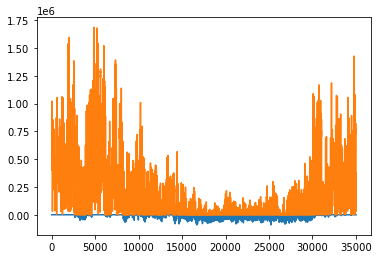

In [5]:
name_list=BIM_test.Type.values.tolist()
area_list=BIM_test.Area.values.tolist()
year_list=BIM_test['Year Built'].values.tolist()
time_array,load_array,load_array2=load_generate(name_list,area_list,year_list)
plt.plot(load_array[0])
plt.plot(load_array2[0])
plt.show()